In [134]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import sklearn.metrics as metrics

In [135]:
COMPANY='AAPL'

In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [137]:
df = pd.read_csv(F'{COMPANY}_data.csv', parse_dates=['Date'],infer_datetime_format=True).set_index('Date')

In [138]:
df.shape

(2933, 54)

In [139]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_10', 'lag_21', 'lag_42', 'lag_63', 'return_1d',
       'return_2d', 'return_3d', 'return_4d', 'return_5d', 'return_10d',
       'return_21d', 'return_42d', 'return_63d', 'rsi', 'bb_high', 'bb_low',
       'atr', 'macd', 'sma_10', 'sma_20', 'sma_50', 'ema_10', 'ema_20',
       'ema_50', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'target_close', 'target_return_1d', 'target_class'],
      dtype='object')

In [140]:

strategy = 'target_class_all_lags'
target = 'target_class'
features =  ['close','lag_1','lag_2','lag_3','lag_4','lag_5','lag_10','lag_21','lag_42','lag_63']
feature_len = len(features)
print(f'features length: {feature_len}')
cols = features.copy()
cols.append(target)
df = df.filter(cols, axis=1)
df.head()

features length: 9


,return_1d,return_2d,return_3d,return_4d,return_5d,return_10d,return_21d,return_42d,return_63d,target_return_1d
Date,,,,,,,,,,
2012-04-03,0.017280,0.049654,0.031909,0.018944,0.024150,0.038550,0.180359,0.382756,0.530336,-0.007961
2012-04-04,-0.007961,0.009182,0.041297,0.023694,0.010832,0.036199,0.177366,0.358140,0.510038,0.015008
2012-04-05,0.015008,0.006928,0.024328,0.056926,0.039058,0.057296,0.194068,0.365778,0.515872,0.004024
2012-04-09,0.004024,0.019093,0.010980,0.028450,0.061179,0.067410,0.173877,0.357059,0.506226,-0.012244
2012-04-10,-0.012244,-0.008269,0.006615,-0.001398,0.015858,0.035356,0.152742,0.318369,0.490148,-0.003565


In [141]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_scaled = sc.fit_transform(df)
print(df_scaled)

[[ 0.90544423  1.92669441  0.96964008 ...  2.94618608  3.23387692
  -0.49403239]
 [-0.49440282  0.29377872  1.28279951 ...  2.73369974  3.09302983
   0.77997049]
 [ 0.77944893  0.20284498  0.71677152 ...  2.79962787  3.1335104
   0.17072007]
 ...
 [-0.44134254 -0.21847119 -0.3525633  ...  0.55883166  0.00498771
  -0.10502883]
 [-0.1054454  -0.39723829 -0.24343137 ...  0.63542496 -0.06675232
   0.12579582]
 [ 0.12535187  0.01464978 -0.25337136 ...  0.65165194 -0.19993795
  -0.35251822]]


In [142]:
# multiple feature from data provided to the model
X = []
backcandles = 60
print(df_scaled.shape[0])
for j in range(feature_len):
    X.append([])
    for i in range(backcandles, df_scaled.shape[0]):
        X[j].append(df_scaled[i-backcandles:i, j])

2933


In [143]:
#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])
X

array([[[ 0.90544423,  1.92669441,  0.96964008, ...,  1.99987241,
          2.94618608,  3.23387692],
        [-0.49440282,  0.29377872,  1.28279951, ...,  1.96251091,
          2.73369974,  3.09302983],
        [ 0.77944893,  0.20284498,  0.71677152, ...,  2.17098461,
          2.79962787,  3.1335104 ],
        ...,
        [-1.13233618, -0.55858417, -0.94719319, ..., -0.13094341,
         -0.91294231, -0.86000928],
        [ 0.06952936, -0.77465116, -0.42036306, ..., -0.03507121,
         -0.86447848, -0.9254234 ],
        [ 0.1865467 ,  0.18697415, -0.53022268, ..., -0.20263971,
         -0.76578951, -0.93051418]],

       [[-0.49440282,  0.29377872,  1.28279951, ...,  1.96251091,
          2.73369974,  3.09302983],
        [ 0.77944893,  0.20284498,  0.71677152, ...,  2.17098461,
          2.79962787,  3.1335104 ],
        [ 0.17027079,  0.69366256,  0.27153284, ...,  1.91897031,
          2.72436158,  3.06657988],
        ...,
        [ 0.06952936, -0.77465116, -0.42036306, ..., -

In [144]:
# Choose -1 for target column
X, yi =np.array(X), np.array(df_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)

[[[ 0.90544423  1.92669441  0.96964008 ...  1.99987241  2.94618608
    3.23387692]
  [-0.49440282  0.29377872  1.28279951 ...  1.96251091  2.73369974
    3.09302983]
  [ 0.77944893  0.20284498  0.71677152 ...  2.17098461  2.79962787
    3.1335104 ]
  ...
  [-1.13233618 -0.55858417 -0.94719319 ... -0.13094341 -0.91294231
   -0.86000928]
  [ 0.06952936 -0.77465116 -0.42036306 ... -0.03507121 -0.86447848
   -0.9254234 ]
  [ 0.1865467   0.18697415 -0.53022268 ... -0.20263971 -0.76578951
   -0.93051418]]

 [[-0.49440282  0.29377872  1.28279951 ...  1.96251091  2.73369974
    3.09302983]
  [ 0.77944893  0.20284498  0.71677152 ...  2.17098461  2.79962787
    3.1335104 ]
  [ 0.17027079  0.69366256  0.27153284 ...  1.91897031  2.72436158
    3.06657988]
  ...
  [ 0.06952936 -0.77465116 -0.42036306 ... -0.03507121 -0.86447848
   -0.9254234 ]
  [ 0.1865467   0.18697415 -0.53022268 ... -0.20263971 -0.76578951
   -0.93051418]
  [-0.57899573 -0.2868747  -0.19523734 ... -0.46936879 -0.57849157
   -0.

In [145]:
test_len = 260
train_end_idx = -test_len
test_start_idx = -test_len
X_train, X_test = X[:train_end_idx], X[test_start_idx:]
y_train, y_test = y[:train_end_idx], y[test_start_idx:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

(2613, 60, 9)
(260, 60, 9)
(2613, 1)
(260, 1)
[[ 1.40469123]
 [ 0.75670474]
 [ 0.59250003]
 ...
 [ 1.01626459]
 [-0.57859259]
 [ 0.60586783]]


In [146]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)

lstm_input = Input(shape=(backcandles, feature_len), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
157/157 [==============================] - 7s 34ms/step - loss: 1.0152 - val_loss: 1.4767
Epoch 2/30
157/157 [==============================] - 5s 32ms/step - loss: 0.9943 - val_loss: 1.5042
Epoch 3/30
157/157 [==============================] - 6s 36ms/step - loss: 0.9915 - val_loss: 1.4982
Epoch 4/30
157/157 [==============================] - 5s 31ms/step - loss: 0.9852 - val_loss: 1.4972
Epoch 5/30
157/157 [==============================] - 6s 37ms/step - loss: 0.9782 - val_loss: 1.5092
Epoch 6/30
157/157 [==============================] - 5s 31ms/step - loss: 0.9781 - val_loss: 1.4863
Epoch 7/30
157/157 [==============================] - 6s 37ms/step - loss: 0.9742 - val_loss: 1.5100
Epoch 8/30
157/157 [==============================] - 5s 31ms/step - loss: 0.9666 - val_loss: 1.5113
Epoch 9/30
157/157 [==============================] - 5s 31ms/step - loss: 0.9536 - val_loss: 1.4985
Epoch 10/30
157/157 [==============================] - 6s 36ms/step - loss: 0.9432 - val_lo

In [147]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

9/9 [==============================] - 0s 17ms/step
[2.058825] [-0.51456375]
[-1.2758497] [0.66698724]
[0.13379279] [0.15728747]
[0.27931118] [-1.25496581]
[-0.2616752] [0.76070279]
[-0.32423663] [0.27623645]
[0.05682434] [-1.13922977]
[0.21718597] [-1.50922055]
[0.11065483] [-1.22545159]
[0.1241769] [2.64277814]


In [148]:
# inverse pred values
import numpy as np
df_copy_pred = np.zeros(shape=(len(y_test), feature_len+1) )
df_copy_pred[:,feature_len] = y_pred[:,0]
df_copy_pred[-1]
y_inversed_pred = sc.inverse_transform(df_copy_pred)[:,feature_len]

In [149]:
# inverse y test values
df_copy_test = np.zeros(shape=(len(y_test), feature_len+1) )
df_copy_test[:,feature_len] = y_test[:,0]
df_copy_test[-1]
y_inversed_test = sc.inverse_transform(df_copy_test)[:,feature_len]

<ipython-input-155-bb9334c0e2c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = y_inversed_pred


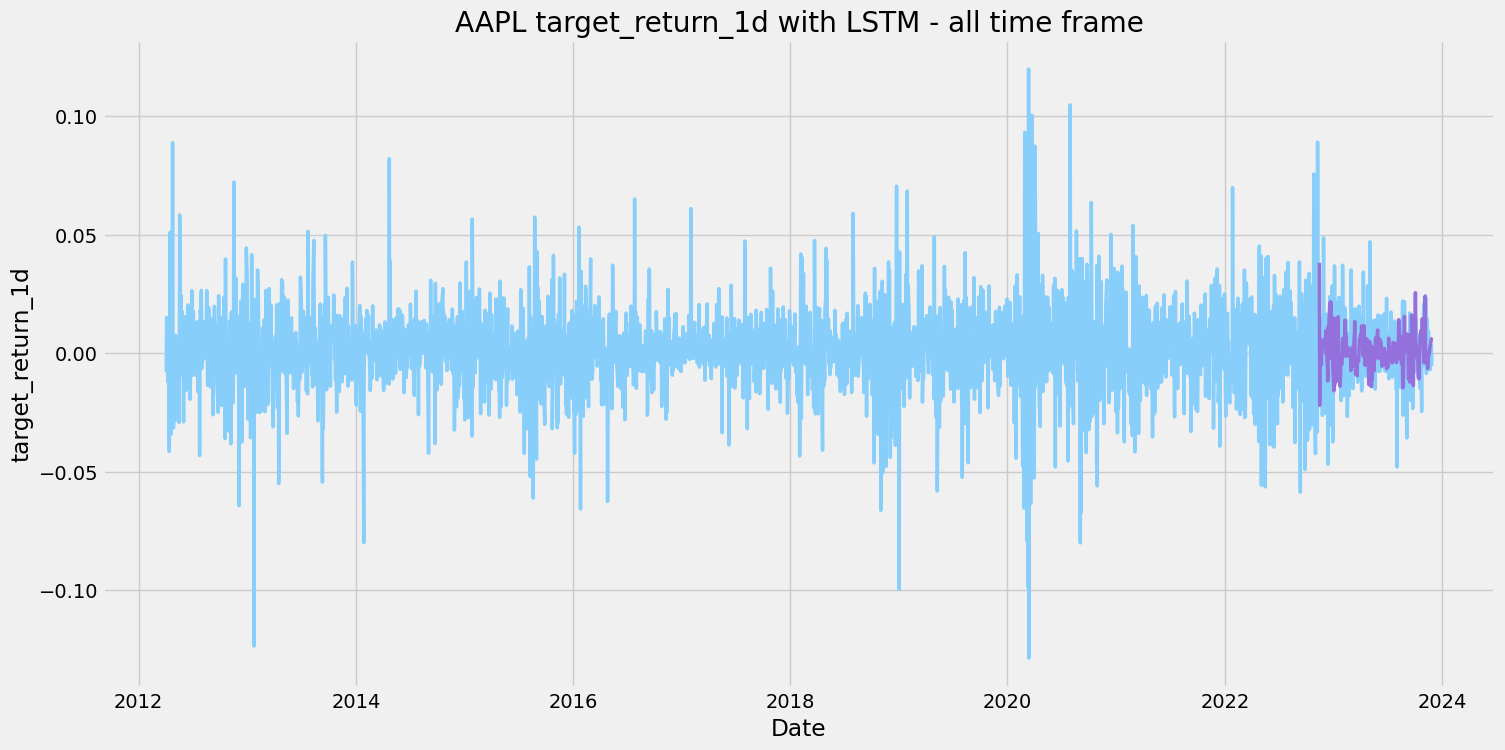

In [155]:
train = df
valid = df.iloc[test_start_idx:]
valid['predictions'] = y_inversed_pred
plt.figure(figsize=(16,8))
plt.title(f'{COMPANY} {target} with LSTM - all time frame')
plt.xlabel('Date')
plt.ylabel(target)
plt.plot(train[target], color='LightSkyBlue', linewidth=2.5, label='True')
plt.plot(valid[['predictions']], color='MediumPurple', linewidth=2.5, label='Predictions')
plt.show()

<ipython-input-158-3c334f13570c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = y_inversed_pred


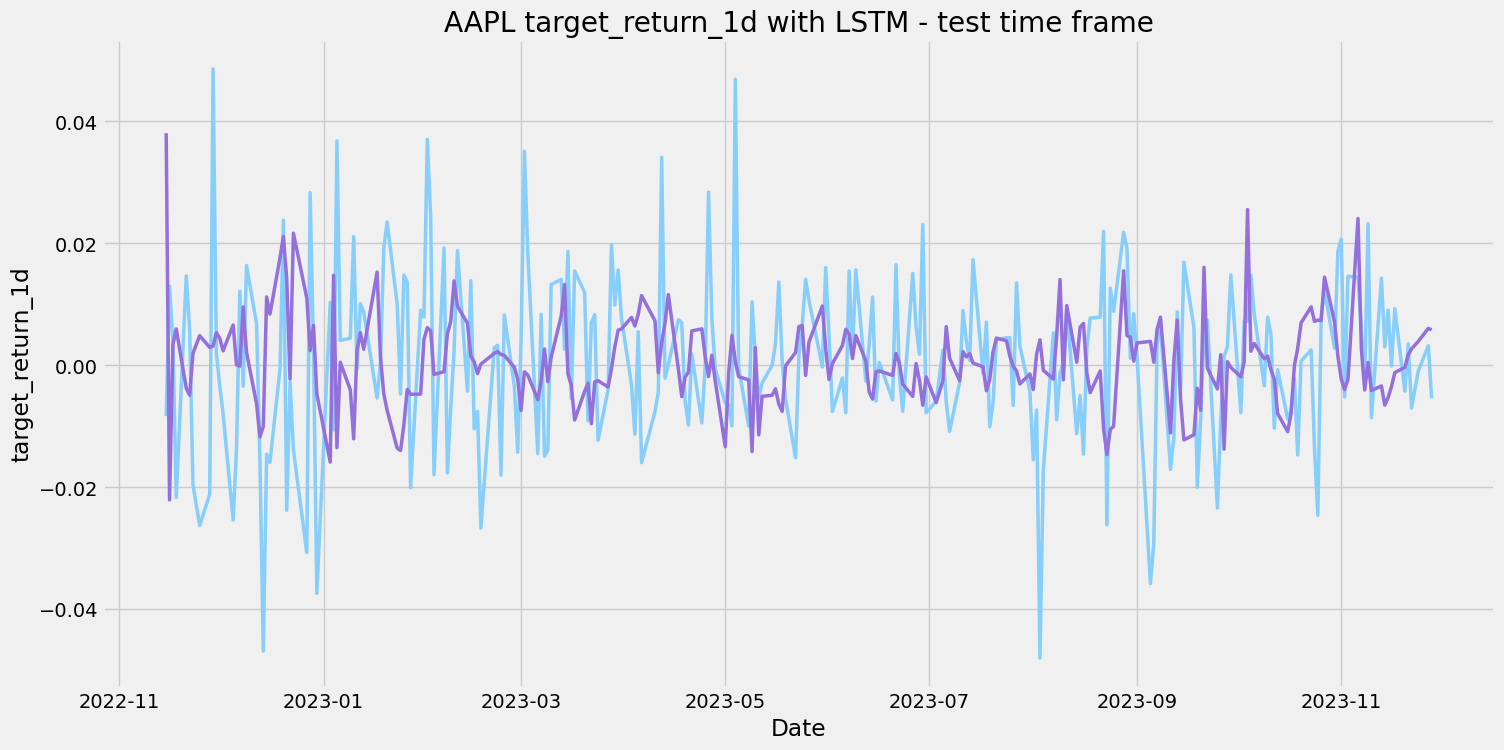

In [158]:
test= df.iloc[test_start_idx:]
valid = df.iloc[test_start_idx:]
valid['predictions'] = y_inversed_pred
plt.figure(figsize=(16,8))
plt.title(f'{COMPANY} {target} with LSTM - test time frame')
plt.xlabel('Date')
plt.ylabel(target)
plt.plot(test[target], color='LightSkyBlue', linewidth=2.5, label='True')
plt.plot(valid[['predictions']], color='MediumPurple', linewidth=2.5, label='Predictions')
plt.show()

In [152]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    output_str = f'explained_variance: {round(explained_variance,4)}\n\
    mean_squared_log_error: {round(mean_squared_log_error,4)}\n\
    r2:  {round(r2,4)}\n\
    MAE:  {round(mean_absolute_error,4)}\n\
    MAE:  {round(median_absolute_error,4)}\n \
    MSE: {round(mse,4)} \n\
    RMSE: {round(np.sqrt(mse),4)} '
    print(f'explained_variance: {round(explained_variance,4)}')
    print(f'mean_squared_log_error: {round(mean_squared_log_error,4)}')
    print(f' r2:  {round(r2,4)}')
    print(f' MAE:  {round(mean_absolute_error,4)}')
    print(f' MedianAE:  {round(median_absolute_error,4)}')
    print(f' MSE: {round(mse,4)}')
    print(f'RMSE: {round(np.sqrt(mse),4)}')

In [153]:
import os

def regression_results(y_true, y_pred, test_len, strategy):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print(f'explained_variance: {round(explained_variance,4)}')
    print(f'r2:  {round(r2,4)}')
    print(f' MAE:  {round(mean_absolute_error,4)}')
    print(f' MedianAE:  {round(median_absolute_error,4)}')
    print(f' MSE: {round(mse,4)}')
    print(f' RMSE: {round(np.sqrt(mse),4)}')
    return pd.Series({'strategy': strategy, 'test_len': test_len, 'explained variance': round(explained_variance,4), 'MAE': round(mean_absolute_error,4),'MedianAE': round(median_absolute_error,4),'MSE' :round(np.sqrt(mse),4), 'R2': round(r2,4), 'RMSE': round(np.sqrt(mse),4) })


reg_result_series = regression_results(y_inversed_test, y_inversed_pred, test_len, strategy)
df_reg_results = pd.DataFrame()
df_reg_results = pd.concat([df_reg_results, reg_result_series.to_frame().T], ignore_index=True)
reg_res_output_path = f"{COMPANY}_reg_test_LSTM_results.csv"
df_reg_results.to_csv(reg_res_output_path, mode='a', header=not os.path.exists(reg_res_output_path))

explained_variance: -0.3324
r2:  -0.3327
 MAE:  0.0125
 MedianAE:  0.0102
 MSE: 0.0003
 RMSE: 0.0163
